# Figure 6, Panels H and I – Make subnetworks

In [67]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [68]:
bedtools_gcc_path = '/project/clark-saucerman/bedtools2/bin:/apps/software/standard/core/gcc/12.2.0/bin'
original_path = os.environ.get('PATH')
os.environ['PATH'] = bedtools_gcc_path + ':' + original_path
lib_path = '/apps/software/standard/core/gcc/12.2.0/lib64'  # Adjust the path if necessary
os.environ['LD_LIBRARY_PATH'] = lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')

In [69]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

'0.14.0'

In [70]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

#### Load links and remove Mef2c connections from KO

In [71]:
def remove_and_filter(links_df, genes_to_remove, num_edges):
    for g in genes_to_remove:
        links_df = links_df.drop(links_df[links_df.source=='Mef2c'].index)
        links_df = links_df.drop(links_df[links_df.target=='Mef2c'].index)
        
    return links_df.sort_values('coef_abs', ascending=False).iloc[:num_edges]

In [72]:
thresh_num = 4000

# With pruning
links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT_cardiac-subset-links.celloracle.links")
links_ko_e85 = co.load_hdf5(file_path="./data/celloracle/e85/KO_cardiac-subset-links.celloracle.links")

links_wt_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko_e85.filtered_links['IFT-CMs_KO'] = remove_and_filter(links_ko_e85.filtered_links['IFT-CMs_KO'], ['Mef2c'], thresh_num)

In [73]:
def return_adata_raw(timepoint):
    adata = sc.read_h5ad(f'data/adata_objects/{timepoint}_subset.h5ad')
    
    if timepoint == 'e85':
        names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                 'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                 'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
    elif timepoint == 'e9':
        names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                        'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                        'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']        
    else:
        return
    
    mapping_dict = dict(zip(range(0, len(names)), names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)    
    
    if timepoint == 'e9':
        adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'
    
    raw_mtx = mmread(f"./data/adata_objects/{timepoint}_matrix.mtx")
    raw_cells = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_cells.csv", header=None)
    raw_genes = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_genes.csv", header=None)
    x = pd.DataFrame(raw_mtx.toarray())
    x.index = raw_genes.values.T[0]
    
    x = x.T
    x.index = raw_cells.values.flatten()
    raw_cells.index = raw_cells.values.flatten()
    raw_genes.index = raw_genes.values.flatten()
    
    new_adata_raw = sc.AnnData(
        X=x.values,  # Use the normalized and log-transformed data
        var=raw_genes,  # Use the same genes
        obs=raw_cells   # Use the same cells
        )
    
    sc.pp.normalize_total(new_adata_raw, target_sum=1e4)
    sc.pp.log1p(new_adata_raw)
    adata.raw = new_adata_raw
    return adata

#### Set timepoint and load adata with raw readouts (req'd for DEG)

In [61]:
timepoint = 'e85'
adata = return_adata_raw(timepoint)

In [62]:
# Chamber is Atrial because assuming adata_E9 is your AnnData object
chamber = 'IFT'

# Filter the data to include only the relevant groups
if timepoint == 'e85':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'{chamber}-CMs_KO', f'{chamber}-CMs_WT'])]
elif timepoint == 'e9':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'CMs-{chamber}_KO', f'CMs-{chamber}_WT'])]
else:
    print('did not filter data')
    
# adata_subset.X = adata_subset.X + 8

sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon')
# sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon', use_raw=False)

# Extract the results into a DataFrame
# import pandas as pd
if timepoint == 'e85':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'{chamber}-CMs_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'{chamber}-CMs_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'{chamber}-CMs_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'{chamber}-CMs_KO']
        }
    )
elif timepoint == 'e9':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'CMs-{chamber}_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'CMs-{chamber}_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'CMs-{chamber}_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'CMs-{chamber}_KO']
        }
    )
else:
    print('oops2')
    
de_results['genes'] = de_results['genes'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

## Load in the networks

I have saved the CellOracle networks as .csv files. They have the following columns:
- `source` – a transcription factor
- `target` – the gene being targeted by the TF
- `coef_mean` – the magnitude of activation (+) or repression (-)
- `coef_abs` – absolute value of `coef_mean`
- `p` – p-value
- `-logp` – negative log p value

### Figures 4 – Subnetworks

This is the `plot_subnetwork()` function. It will return a `networkx` network for visualization.

In [63]:
def plot_subnetwork(network, tf_genes, targets):
    graph_df = {'source': [],
                 'target': [],
                 'weight': [],
                 'edge_cols': []}
    
    for curr_gene in tf_genes:
        curr_gene_df = network[network['source'] == curr_gene]
        gene_df_targs = curr_gene_df[curr_gene_df['target'].isin(targets)]

        for index, row in gene_df_targs.iterrows():
            graph_df['source'].append(row['source'])
            graph_df['target'].append(row['target'])
            graph_df['weight'].append(row['coef_mean'])
            if row['coef_mean'] > 0:
                graph_df['edge_cols'].append('green')
            else:
                graph_df['edge_cols'].append('red')

    graph_df = pd.DataFrame(graph_df)

    G = nx.from_pandas_edgelist(graph_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    
    from pyvis.network import Network
    net = Network(notebook=True, directed=True)
    net.from_nx(G)

    for edge in net.edges:
        if edge['width'] > 0:
            edge['color'] = 'grey'
            edge['arrowStrikethrough'] = False
        else:
            edge['color'] = 'red'
            edge['arrows'] = {"to": {"enabled": True, "type": "bar", "scaleFactor":.4}}

        edge['value'] = np.abs(edge['width'])


    for node in net.nodes:
        if node['id'] in tf_genes:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 10
            node['font'] = {'size': 40, 'color': 'black'}
        else:
            node['color'] = 'grey' # Black is neither
            node['font'] = {'size': 16, 'color': 'black'}
            node['size'] = 2
            
        if node['id'] in ['Gata4', 'Nr2f2']:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 20
            node['font'] = {'size': 40, 'color': 'black'}
        

    G_act = nx.from_pandas_edgelist(graph_df[graph_df.weight > 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    G_inact = nx.from_pandas_edgelist(graph_df[graph_df.weight < 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
            
    return net, G_act, G_inact

### Visualize a subnetwork

Visualizing networks is very helpful, but it is difficult to make sense of the CellOracle network when observed in its entirety. I find it useful to focus in on a handfull of genes/transcription factors of interest. We have discussed starting with a few of the sarcomeric proteins that we know to be differentially expressed. 

Add/remove genes from the `tf_genes` and `targets` list to visualize the subnetworks of interest.

In [64]:
de_results.sort_values('pvals', ascending=True)
de_subset = de_results[de_results.pvals <1E-7]

In [66]:
links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT_cardiac-subset-links.celloracle.links")

links_wt_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)

tf_genes = ['Mef2a', 'Mef2c', 'Nr2f2', 'Tbx5', 'Gata4', 'Meis2', 'Plagl1',
            'Isl1', 'Pitx2', 'Tbx20', 'Hand2', 'Nkx2-5']

# targets = list(de_subset.genes.values)[:100]

targets += tf_genes

net, G_act, G_inact = plot_subnetwork(links_wt_e85.filtered_links['IFT-CMs_WT'], tf_genes, targets)
net.show('net.html')

net.html


In [16]:
net, G_act, G_inact = plot_subnetwork(links_ko_e85.filtered_links['IFT-CMs_KO'], tf_genes, targets)
net.show('net.html')

net.html


### Panel I – Nr2f2 AND Gata4 direct connections

In [76]:
def get_gene_targets(tf, links_wt, links_ko):
    wt_targets = links_wt[links_wt.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    ko_targets = links_ko[links_ko.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    
    intersect_targets = [x for x in wt_targets if x in ko_targets]
    
    wt_only_targets = [x for x in wt_targets if x not in ko_targets]

    ko_only_targets = [x for x in ko_targets if x not in wt_targets]
    
    return intersect_targets, wt_only_targets, ko_only_targets

tf = 'Gata4'

links_wt = links_wt_e85.filtered_links['IFT-CMs_WT']
links_ko = links_ko_e85.filtered_links['IFT-CMs_KO']

intersect_targets, wt_targets, ko_targets = get_gene_targets(tf, links_wt, links_ko)

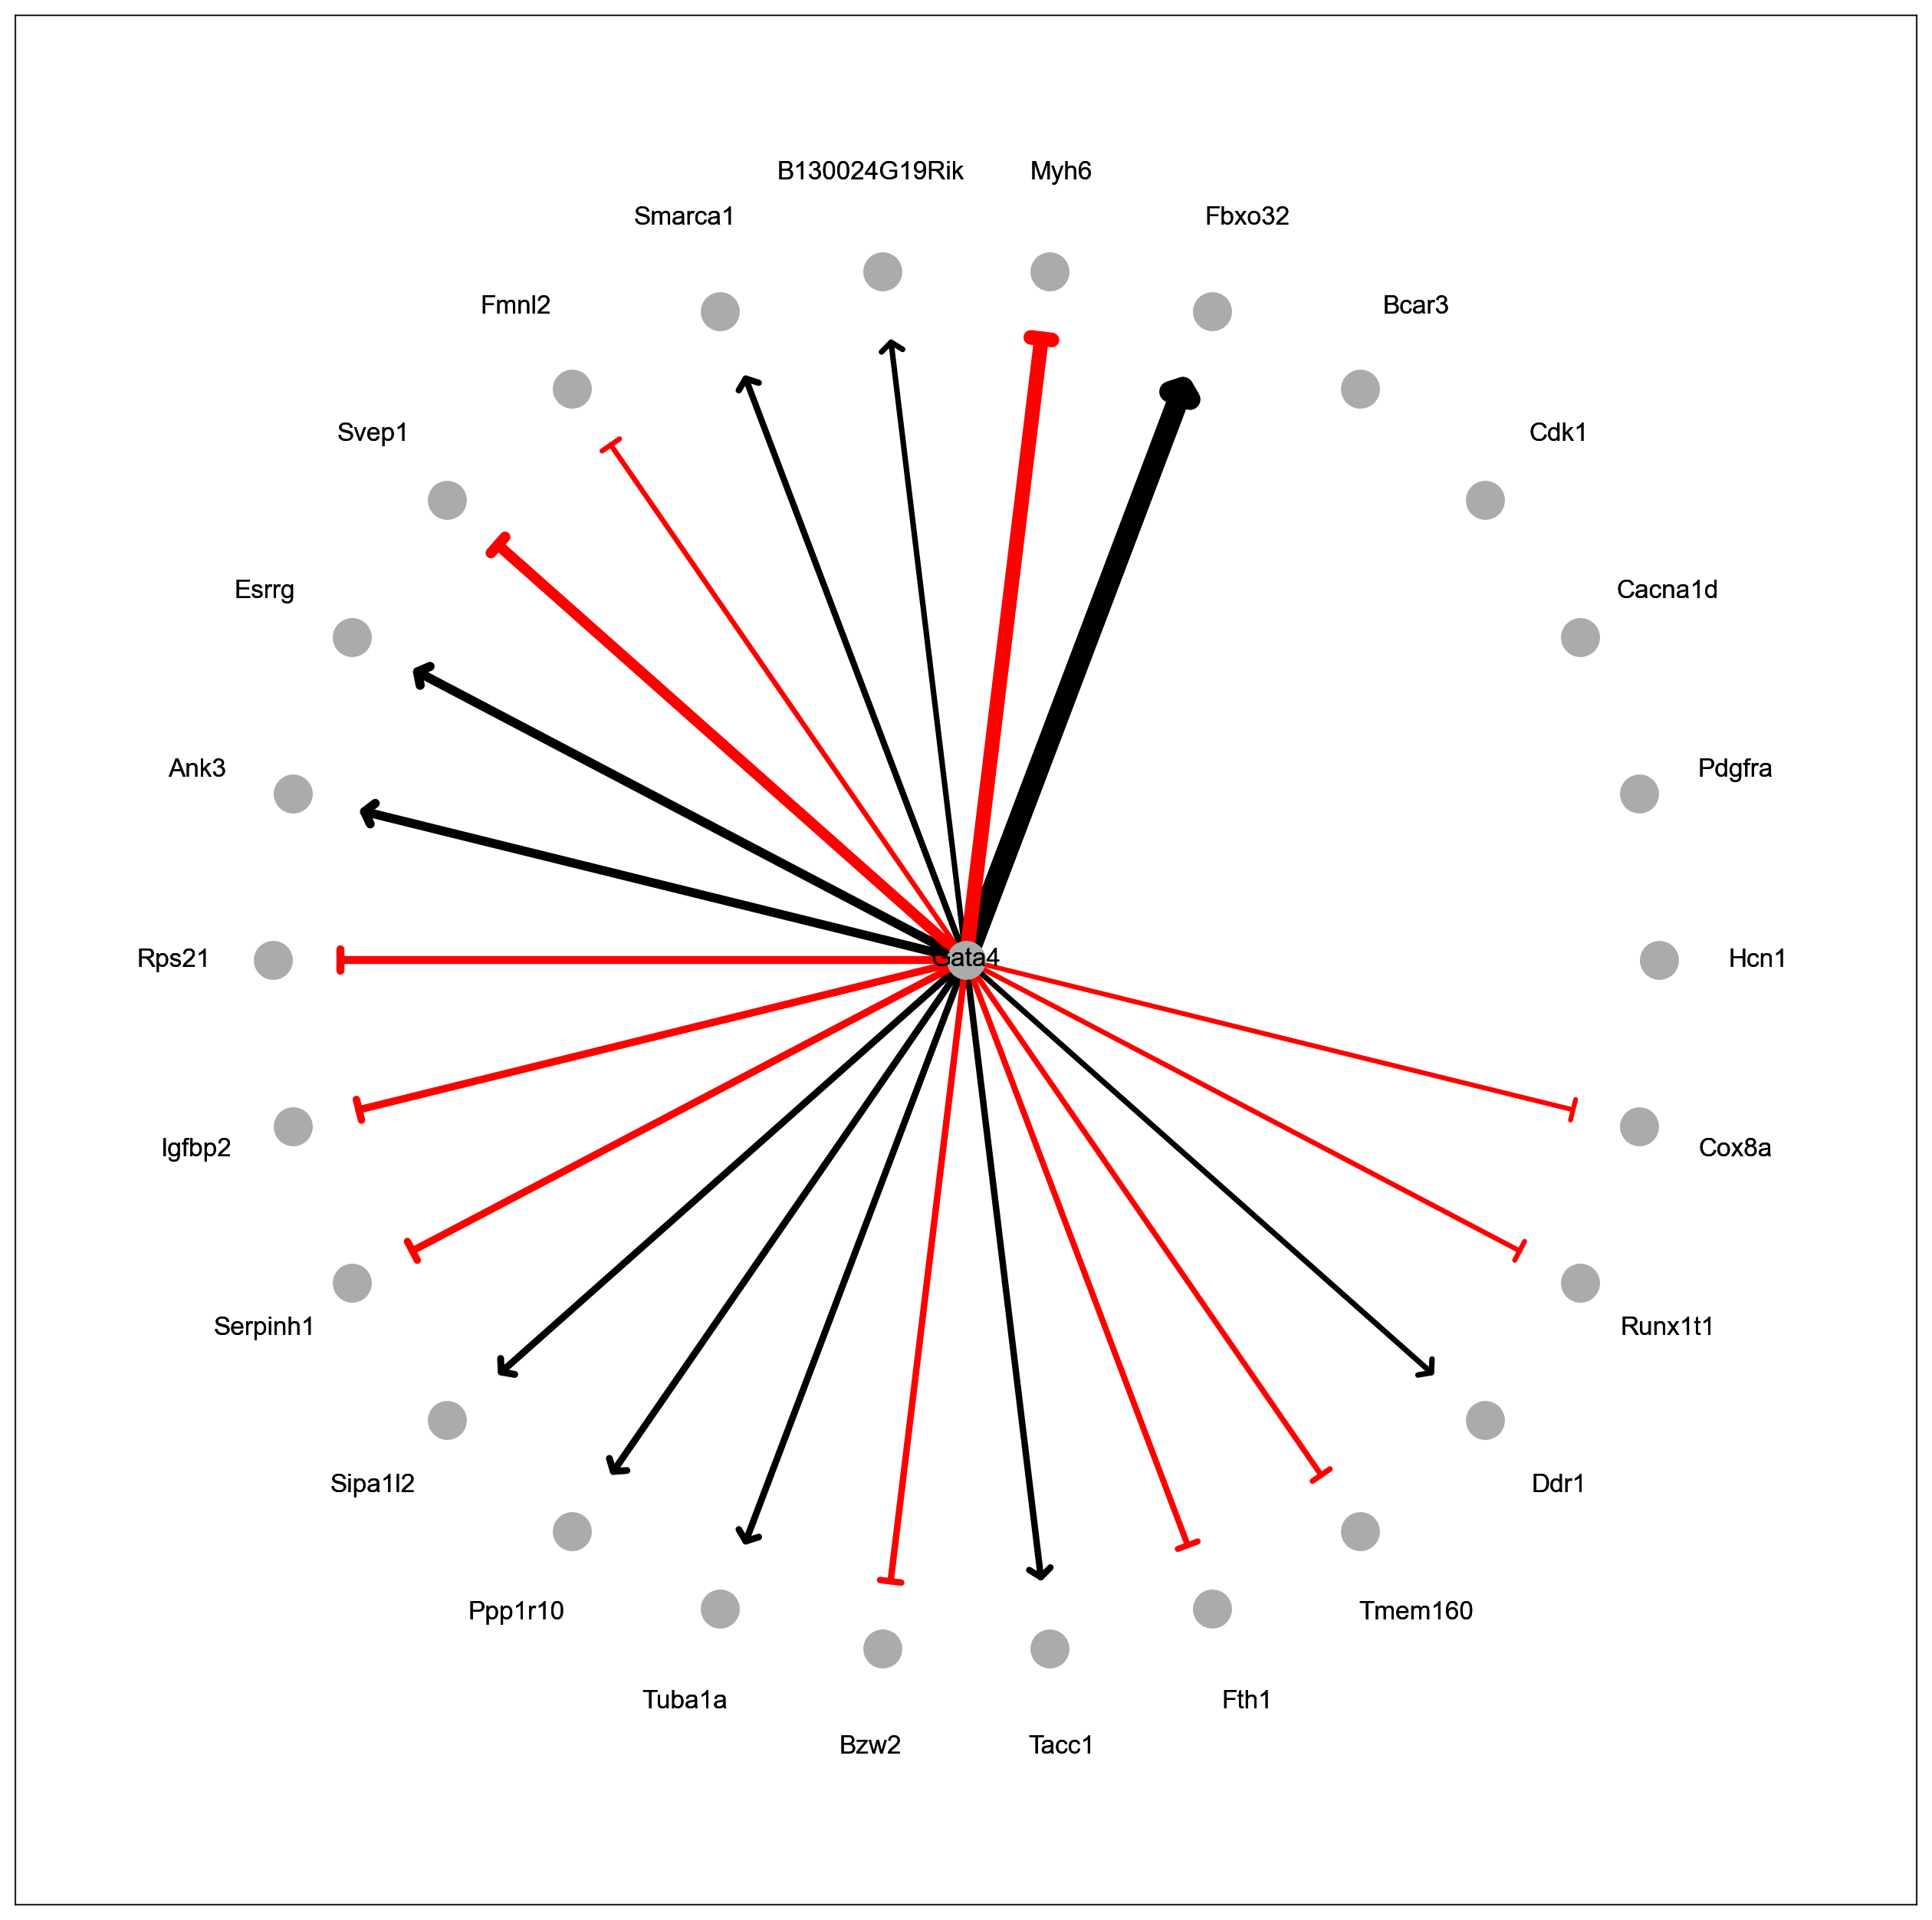

In [78]:
import networkx as nx
import numpy as np
import math
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rc('font', family='Arial')
fig, ax = plt.subplots(figsize=(16, 16))

all_nodes = wt_targets + intersect_targets +  ko_targets

G_act = nx.DiGraph()
G_act.add_nodes_from(all_nodes)
G_inhib = nx.DiGraph()
G_inhib.add_nodes_from(all_nodes)

pos = nx.circular_layout(G_act.subgraph(all_nodes))

G_act.add_node(tf)
G_inhib.add_node(tf)

tf_links = links_wt[links_wt.source == tf]
tf_links = links_ko[links_ko.source == tf]
    
for x in tf_links.target:
    connection = tf_links[tf_links.target == x]
    if connection.coef_mean.values[0] < 0:
        G_inhib.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='red')
    else:
        G_act.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='black')
        

for i, G in enumerate([G_act, G_inhib]):
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    center_node = tf
    pos[center_node] = np.array([0, 0])
    
    pos_higher = nx.rescale_layout_dict(pos, 16)
    nx.draw_networkx_labels(G, pos_higher)
    
    pos_lower = nx.rescale_layout_dict(pos, 13)
    # nx.draw_networkx_nodes(G, pos, node_color="#005D32")

    if i == 0:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('->', head_length=0.4, head_width=0.5))
    else:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('|-|', widthA=0, angleA=0, widthB=.5, angleB=0))


pos_mid = nx.rescale_layout_dict(pos, 14)
nx.draw_networkx_nodes(G, pos_mid, node_color="#ababab")

x_values, y_values = zip(*pos_higher.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(float(x_min - x_margin), float(x_max + x_margin))

y_max = max(y_values)
y_min = min(y_values)
y_margin = (y_max - y_min) * 0.1
plt.ylim(float(y_min - y_margin), float(y_max + y_margin))
plt.savefig("./data/gata4-wt.pdf", format='pdf')
# plt.show()
